# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

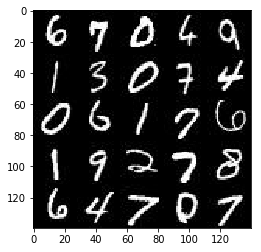

In [33]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

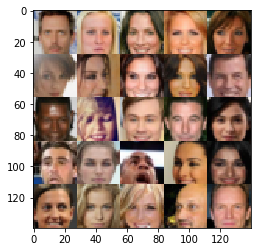

In [34]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [36]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):

    Real_Input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, 
                                                                image_channels), 
                                       name="real_input")
    Z_Data = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="z_data")
    Learning_Rate = tf.placeholder(dtype=tf.float32,name="learning_rate")

    return Real_Input, Z_Data, Learning_Rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [37]:
def discriminator(images, reuse=False, is_train=True):
    with tf.variable_scope("discriminator", reuse=reuse):
        
        a = 0.2
        
        Initializer1 = tf.contrib.layers.xavier_initializer()
        Conv1 = tf.layers.conv2d(images, 64, 5 ,strides=2 , padding='same', kernel_initializer=Initializer1)
        relu1 = tf.maximum(a*Conv1, Conv1)
        do1 = tf.nn.dropout(relu1, 0.70)
        
        
        Initializer2 = tf.contrib.layers.xavier_initializer()
        Conv2 = tf.layers.conv2d(do1, 128, 5 ,strides=1 , padding='same', kernel_initializer=Initializer2)
        batchnorm2= tf.layers.batch_normalization(Conv2, training=is_train)
        relu2 = tf.maximum(a*batchnorm2, batchnorm2)
        do2 = tf.nn.dropout(relu2, 0.70)
        
        Initializer3 = tf.contrib.layers.xavier_initializer()
        Conv3 = tf.layers.conv2d(do2, 256, 5 ,strides=2 , padding='same', kernel_initializer=Initializer3)
        batchnorm3= tf.layers.batch_normalization(Conv3, training=is_train)
        relu3 = tf.maximum(a*batchnorm3, batchnorm3)
        do3 = tf.nn.dropout(relu3, 0.70)
        
        Initializer4 = tf.contrib.layers.xavier_initializer()
        Conv4 = tf.layers.conv2d(do3, 512, 5 ,strides=1 , padding='same', kernel_initializer=Initializer4)
        batchnorm4= tf.layers.batch_normalization(Conv4, training=is_train)
        relu4 = tf.maximum(a*batchnorm4, batchnorm4)
        do4 = tf.nn.dropout(relu4, 0.70)
        
        
        Logits = tf.layers.dense(tf.reshape(do4, (-1,7*7*512)),1)
        Output = tf.sigmoid(Logits)
    
    return Output, Logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [38]:
def generator(z, out_channel_dim, is_train=True):
    with tf.variable_scope("generator", reuse=not is_train):
        a = 0.2
            
        dense_layer = tf.layers.dense(z, 7*7*1024)
        reshape = tf.reshape(dense_layer, (-1,7,7,1024))
        batchnorm1= tf.layers.batch_normalization(reshape, training=is_train)
        relu1 = tf.maximum(a*batchnorm1,batchnorm1)
        do1 = tf.nn.dropout(relu1, 0.8)
        
        
        
        conv2 = tf.layers.conv2d_transpose(do1, 512, 5, strides=1, padding='same')
        batchnorm2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(a*batchnorm2,batchnorm2)
        do2 = tf.nn.dropout(relu2, 0.8)
        
        conv3 = tf.layers.conv2d_transpose(do2, 256, 5, strides=2, padding='same')
        batchnorm3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(a*batchnorm3,batchnorm3)
        do3 = tf.nn.dropout(relu3, 0.8)
        
        conv4 = tf.layers.conv2d_transpose(do3, 128, 5, strides=1, padding='same')
        batchnorm4 = tf.layers.batch_normalization(conv4, training=is_train)
        relu4 = tf.maximum(a*batchnorm4,batchnorm4)
        do4 = tf.nn.dropout(relu4, 0.8)
        
        logits = tf.layers.conv2d_transpose(do4, out_channel_dim, 5, strides=2, padding='same')
                       
        Gen_img = tf.tanh(logits)
    
        return Gen_img


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [39]:
def model_loss(input_real, input_z, out_channel_dim):
    
    a = 0.2
    
    gen = generator(input_z,out_channel_dim)
    discrim_real, discrim_real_logits = discriminator(input_real)
    discrim_fake, discrim_fake_logits = discriminator(gen, reuse=True)
    
    discrim_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_fake_logits, 
                                                labels=tf.zeros_like(discrim_fake)
                                               ) )
    sf = 0.1
    discrim_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_real_logits, 
                                                labels=tf.ones_like(discrim_real)*(1-sf)
                                               ) )
    
    gen_loss =  tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_fake_logits, 
                                                labels=tf.ones_like(discrim_fake)
                                               ) )
    
    discrim_loss = discrim_fake_loss + discrim_real_loss
    
    return discrim_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [40]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    
    
    t_vars = tf.trainable_variables()
    gen_vars = [var for var in t_vars if var.name.startswith('generator')]
    discrim_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    update = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [ u for u in update if u.name.startswith('generator')]
    discrim_train_omtim = tf.train.AdamOptimizer(
        learning_rate=learning_rate,beta1=beta1).minimize(d_loss, var_list=discrim_vars)
    
    with tf.control_dependencies(gen_updates):
        gen_train_optim = tf.train.AdamOptimizer(
        learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return discrim_train_omtim, gen_train_optim


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [42]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):

    # TODO: Build Model
    
    input_real, input_z, Learning_Rate = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    
    discrim_loss, gen_loss = model_loss(input_real, input_z, data_shape[3])
    discrim_train_optim, gen_train_optim = model_opt(discrim_loss, gen_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                step += 1 
                batch_images *= 2 
                
                #gen input
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                #run
                _ = sess.run(discrim_train_optim, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(gen_train_optim, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if step % 10 == 0:
                    train_discrim_loss = discrim_loss.eval({input_z:batch_z, input_real: batch_images})
                    train_gen_loss = gen_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_discrim_loss),
                          "Generator Loss: {:.4f}".format(train_gen_loss))
                
                if step % 100 == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode) 
            show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)           

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 3.0662
Epoch 1/2... Discriminator Loss: 2.4062... Generator Loss: 0.5447
Epoch 1/2... Discriminator Loss: 2.4219... Generator Loss: 0.4203
Epoch 1/2... Discriminator Loss: 3.5113... Generator Loss: 0.1936
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 1.5026
Epoch 1/2... Discriminator Loss: 2.4112... Generator Loss: 0.5957
Epoch 1/2... Discriminator Loss: 4.5378... Generator Loss: 2.6847
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 1.3122
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 3.3478
Epoch 1/2... Discriminator Loss: 1.1055... Generator Loss: 1.7567


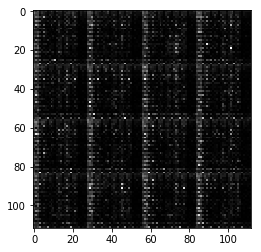

Epoch 1/2... Discriminator Loss: 2.2520... Generator Loss: 3.5148
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 3.9219
Epoch 1/2... Discriminator Loss: 0.5657... Generator Loss: 3.6312
Epoch 1/2... Discriminator Loss: 1.8981... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 1.6794... Generator Loss: 1.0397
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 1.5318
Epoch 1/2... Discriminator Loss: 1.8055... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 2.0389
Epoch 1/2... Discriminator Loss: 1.6526... Generator Loss: 0.8605
Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 2.1417


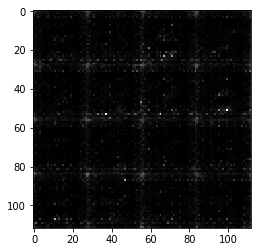

Epoch 1/2... Discriminator Loss: 1.3034... Generator Loss: 2.0017
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 1.7958
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 1.7396
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 1.3567
Epoch 1/2... Discriminator Loss: 1.6020... Generator Loss: 2.3761
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 1.1864
Epoch 1/2... Discriminator Loss: 1.5705... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 1.6139... Generator Loss: 0.9625
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 1.1398
Epoch 1/2... Discriminator Loss: 1.6747... Generator Loss: 1.1371


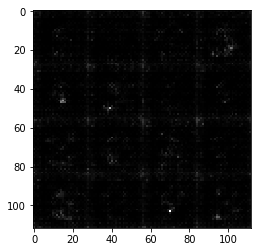

Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 1.4692
Epoch 1/2... Discriminator Loss: 1.7679... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 1.8333
Epoch 1/2... Discriminator Loss: 1.6270... Generator Loss: 1.7982
Epoch 1/2... Discriminator Loss: 1.5705... Generator Loss: 1.2729
Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 1.3044
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.8363
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.6091... Generator Loss: 1.5672


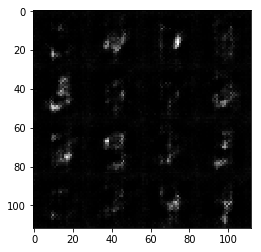

Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 1.2263
Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 1.4988... Generator Loss: 0.7860
Epoch 1/2... Discriminator Loss: 1.5580... Generator Loss: 0.7282
Epoch 1/2... Discriminator Loss: 1.5293... Generator Loss: 1.0746
Epoch 1/2... Discriminator Loss: 1.5517... Generator Loss: 0.8335
Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 0.6510
Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 1.2591
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 1.8623
Epoch 1/2... Discriminator Loss: 1.4495... Generator Loss: 1.0052


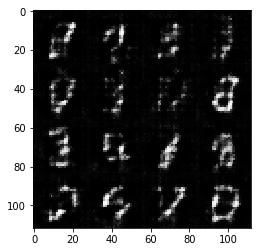

Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 1.3719
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 1.2270
Epoch 1/2... Discriminator Loss: 1.1643... Generator Loss: 1.1907
Epoch 1/2... Discriminator Loss: 1.2328... Generator Loss: 1.3827
Epoch 1/2... Discriminator Loss: 1.6085... Generator Loss: 1.2526
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 0.9218
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 0.6685
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 0.7405
Epoch 1/2... Discriminator Loss: 1.2729... Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.9536


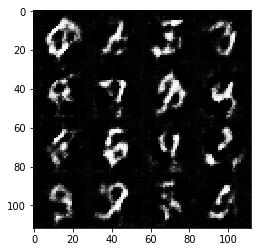

Epoch 1/2... Discriminator Loss: 1.1789... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 1.7136
Epoch 1/2... Discriminator Loss: 1.3372... Generator Loss: 0.8110
Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.3320... Generator Loss: 1.0135
Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 1.0571
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 1.1175
Epoch 1/2... Discriminator Loss: 1.3643... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 1.2443
Epoch 1/2... Discriminator Loss: 1.6539... Generator Loss: 0.5131


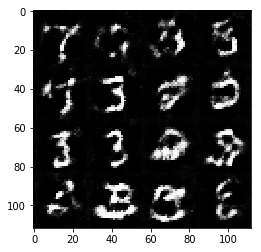

Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 1.1322
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 0.9143
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 1.6070
Epoch 1/2... Discriminator Loss: 1.5575... Generator Loss: 0.5773
Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 1.1914
Epoch 1/2... Discriminator Loss: 1.8526... Generator Loss: 0.3835
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 1.4230
Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 0.9686


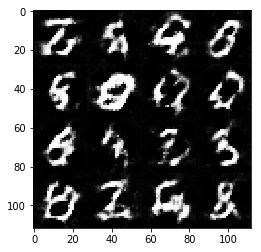

Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 1.0546
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.9955
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 1.8627
Epoch 1/2... Discriminator Loss: 1.4899... Generator Loss: 1.7408
Epoch 1/2... Discriminator Loss: 1.5362... Generator Loss: 0.6941
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 1.1227
Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 1.4509... Generator Loss: 0.6843


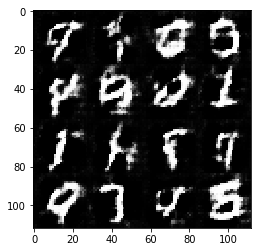

Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.8537
Epoch 1/2... Discriminator Loss: 1.8462... Generator Loss: 0.5350
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 1.5971
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 1.0448
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.9195
Epoch 1/2... Discriminator Loss: 1.5716... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 1.1316
Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 1.4946


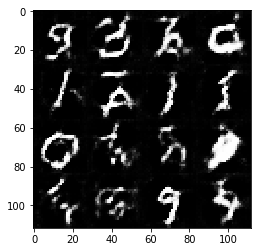

Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 1.5730
Epoch 1/2... Discriminator Loss: 1.8550... Generator Loss: 2.2986
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 1.3471... Generator Loss: 1.5250
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 1.3729
Epoch 1/2... Discriminator Loss: 1.5257... Generator Loss: 1.8267
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 1.6704
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 1.0663
Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 1.6434


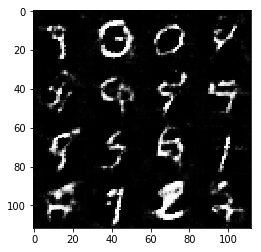

Epoch 1/2... Discriminator Loss: 1.6704... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 1.5243
Epoch 1/2... Discriminator Loss: 1.4827... Generator Loss: 1.1785
Epoch 1/2... Discriminator Loss: 1.5873... Generator Loss: 0.5912
Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 1.3666
Epoch 1/2... Discriminator Loss: 1.4962... Generator Loss: 0.5848
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 1.3979
Epoch 1/2... Discriminator Loss: 1.8283... Generator Loss: 2.3275
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 1.0280


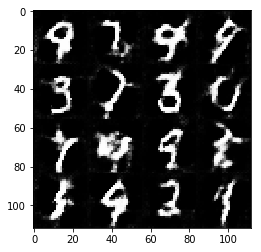

Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.8084
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.8939
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.9028
Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 0.6258
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 1.1010
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.8009
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 1.4018
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.8686
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 1.0695
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 1.2102


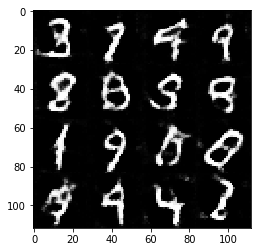

Epoch 1/2... Discriminator Loss: 1.1698... Generator Loss: 1.3837
Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 1.4770
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.9260
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.8496
Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 1.2317
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 1.2366
Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 1.5415
Epoch 1/2... Discriminator Loss: 1.4320... Generator Loss: 1.1303


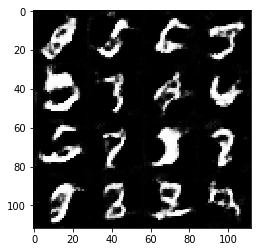

Epoch 1/2... Discriminator Loss: 1.5580... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 1.4300
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 1.1657
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 1.1283
Epoch 1/2... Discriminator Loss: 1.4499... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 1.4302
Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.8478
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 0.8122
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.9076
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 0.8272


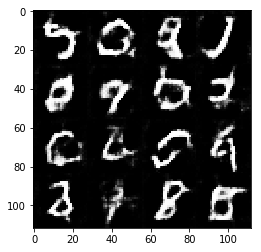

Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 1.6248
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 0.8915
Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 1.0417
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 0.9318
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 1.4955
Epoch 1/2... Discriminator Loss: 2.0212... Generator Loss: 2.0024
Epoch 1/2... Discriminator Loss: 1.7328... Generator Loss: 2.5637
Epoch 1/2... Discriminator Loss: 1.3840... Generator Loss: 0.6805
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 2.5426
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 1.4018


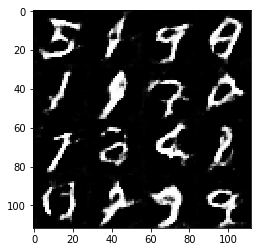

Epoch 1/2... Discriminator Loss: 1.4436... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 2.1980
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 0.9740
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 1.3562
Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 1.4639
Epoch 1/2... Discriminator Loss: 1.5197... Generator Loss: 0.5117


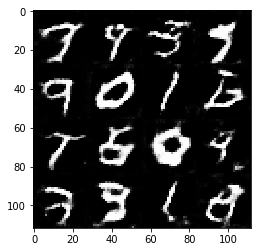

Epoch 1/2... Discriminator Loss: 1.6321... Generator Loss: 2.8534
Epoch 1/2... Discriminator Loss: 1.0789... Generator Loss: 1.3520
Epoch 1/2... Discriminator Loss: 1.1195... Generator Loss: 1.4747
Epoch 1/2... Discriminator Loss: 1.5114... Generator Loss: 2.0561
Epoch 1/2... Discriminator Loss: 1.2694... Generator Loss: 1.5629
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 1.6261... Generator Loss: 0.5205
Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 1.7780
Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 1.4230
Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 1.3528


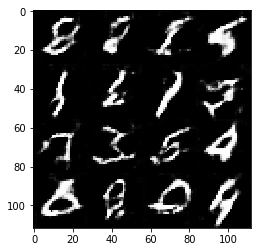

Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 1.2025
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 1.9505
Epoch 1/2... Discriminator Loss: 1.2011... Generator Loss: 1.7686
Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 1.3054
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.0328... Generator Loss: 1.1302


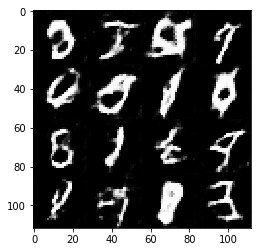

Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 1.4171
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 0.7666
Epoch 2/2... Discriminator Loss: 1.1516... Generator Loss: 1.5700
Epoch 2/2... Discriminator Loss: 1.8875... Generator Loss: 0.4308
Epoch 2/2... Discriminator Loss: 1.5286... Generator Loss: 0.4437
Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 1.3011
Epoch 2/2... Discriminator Loss: 1.8748... Generator Loss: 0.4487
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.3823
Epoch 2/2... Discriminator Loss: 1.4976... Generator Loss: 0.5437
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.7081


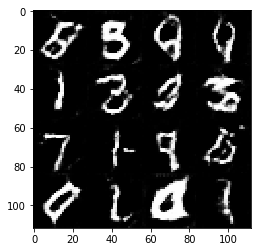

Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 1.0285
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 1.0077
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 1.3090
Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 1.5898
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 2.0908
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 2.3519
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 1.9963
Epoch 2/2... Discriminator Loss: 0.9138... Generator Loss: 1.4656
Epoch 2/2... Discriminator Loss: 0.8965... Generator Loss: 2.0239
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 2.0208


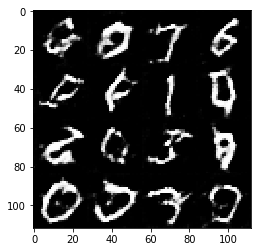

Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 1.1058
Epoch 2/2... Discriminator Loss: 1.2662... Generator Loss: 1.9511
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 1.1050
Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 1.4747
Epoch 2/2... Discriminator Loss: 1.2051... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.7684
Epoch 2/2... Discriminator Loss: 1.1878... Generator Loss: 0.8699
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 1.2374
Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 2.1513


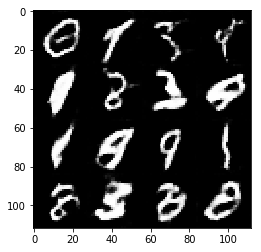

Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 1.5188
Epoch 2/2... Discriminator Loss: 1.4661... Generator Loss: 0.6539
Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 2.2791
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 0.9965
Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 1.0902
Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 1.2090
Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 1.2441
Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 1.8992
Epoch 2/2... Discriminator Loss: 1.0769... Generator Loss: 1.9381


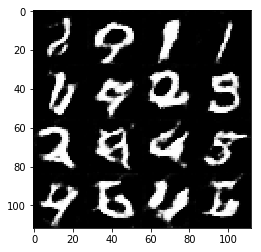

Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.9492
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 1.5162
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 1.2839
Epoch 2/2... Discriminator Loss: 0.9051... Generator Loss: 1.0951
Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 1.0166
Epoch 2/2... Discriminator Loss: 0.8898... Generator Loss: 1.6010
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 1.5189
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 1.8147
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 1.8520
Epoch 2/2... Discriminator Loss: 2.0494... Generator Loss: 0.3566


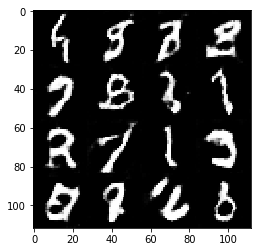

Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 1.5387
Epoch 2/2... Discriminator Loss: 1.1619... Generator Loss: 1.1858
Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 1.8951
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 1.7453
Epoch 2/2... Discriminator Loss: 1.9454... Generator Loss: 0.3645
Epoch 2/2... Discriminator Loss: 0.8929... Generator Loss: 1.4103
Epoch 2/2... Discriminator Loss: 1.1299... Generator Loss: 0.8152
Epoch 2/2... Discriminator Loss: 2.2128... Generator Loss: 4.2355
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 1.1841
Epoch 2/2... Discriminator Loss: 1.4734... Generator Loss: 2.1956


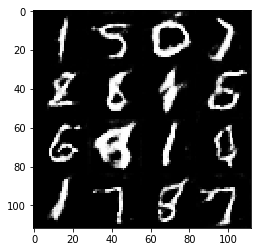

Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 1.0209
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 2.1638
Epoch 2/2... Discriminator Loss: 2.2194... Generator Loss: 0.1820
Epoch 2/2... Discriminator Loss: 1.1458... Generator Loss: 1.2047
Epoch 2/2... Discriminator Loss: 1.6519... Generator Loss: 0.5567
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 1.2778
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 2.6460
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 1.5198
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.4801
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 2.4990


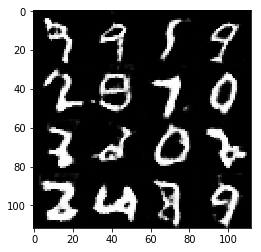

Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.1819
Epoch 2/2... Discriminator Loss: 1.1497... Generator Loss: 2.2591
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.8269
Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 1.8775
Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 0.8544
Epoch 2/2... Discriminator Loss: 1.0919... Generator Loss: 1.5542
Epoch 2/2... Discriminator Loss: 1.4078... Generator Loss: 0.8302
Epoch 2/2... Discriminator Loss: 1.6258... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 0.9698... Generator Loss: 1.4795
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 1.4965


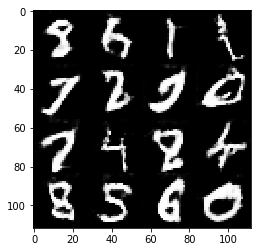

Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 1.3414
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 1.6310
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 1.2224
Epoch 2/2... Discriminator Loss: 0.9012... Generator Loss: 0.9848
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.4964
Epoch 2/2... Discriminator Loss: 1.3608... Generator Loss: 0.7631
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 2.4779
Epoch 2/2... Discriminator Loss: 0.8434... Generator Loss: 2.1070
Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 1.9075


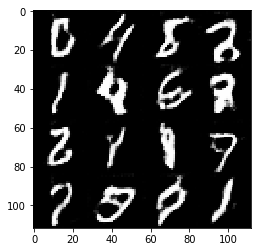

Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 1.7549
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 1.2297
Epoch 2/2... Discriminator Loss: 0.8543... Generator Loss: 2.0394
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.8110
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 1.8081
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 1.5264
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 1.1699
Epoch 2/2... Discriminator Loss: 1.1193... Generator Loss: 1.2835
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 1.1666


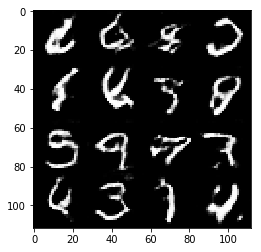

Epoch 2/2... Discriminator Loss: 0.9571... Generator Loss: 1.5973
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.9567
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 2.5986
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 1.6923
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 1.8166
Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 1.4613
Epoch 2/2... Discriminator Loss: 0.9112... Generator Loss: 1.4787
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 1.7066
Epoch 2/2... Discriminator Loss: 1.1845... Generator Loss: 1.8137
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 2.4764


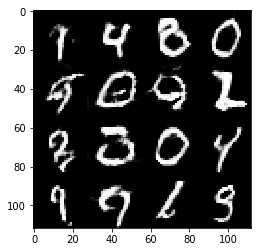

Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.7791
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 1.1983
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 1.0624
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 1.4412
Epoch 2/2... Discriminator Loss: 1.1012... Generator Loss: 3.2868
Epoch 2/2... Discriminator Loss: 1.0279... Generator Loss: 1.5906
Epoch 2/2... Discriminator Loss: 1.0095... Generator Loss: 1.5651
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 1.4637
Epoch 2/2... Discriminator Loss: 1.0524... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 0.9321


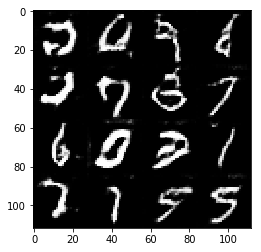

Epoch 2/2... Discriminator Loss: 0.8327... Generator Loss: 1.5525
Epoch 2/2... Discriminator Loss: 1.5619... Generator Loss: 0.8122
Epoch 2/2... Discriminator Loss: 1.4441... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 2.1581... Generator Loss: 0.2000
Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 1.2465
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 2.5118
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 2.7785
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 0.9597
Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 1.2375
Epoch 2/2... Discriminator Loss: 0.8789... Generator Loss: 1.9446


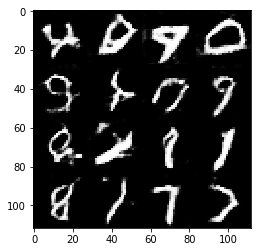

Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.8364
Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 2.2640
Epoch 2/2... Discriminator Loss: 1.0962... Generator Loss: 2.8420
Epoch 2/2... Discriminator Loss: 0.9753... Generator Loss: 2.8140
Epoch 2/2... Discriminator Loss: 0.8557... Generator Loss: 1.9659
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 1.2619
Epoch 2/2... Discriminator Loss: 1.4381... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 0.8387... Generator Loss: 1.4260
Epoch 2/2... Discriminator Loss: 1.4930... Generator Loss: 1.0808
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 1.7515


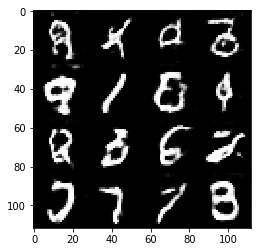

Epoch 2/2... Discriminator Loss: 1.4472... Generator Loss: 1.1676
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 1.1348
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 1.4042
Epoch 2/2... Discriminator Loss: 1.5468... Generator Loss: 0.7479
Epoch 2/2... Discriminator Loss: 0.7442... Generator Loss: 1.4518
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 3.8732
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 1.1150
Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 1.4430
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 0.8621
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 1.8738


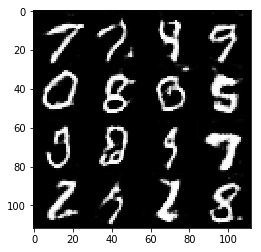

Epoch 2/2... Discriminator Loss: 0.6579... Generator Loss: 2.1994
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 1.0613
Epoch 2/2... Discriminator Loss: 0.6203... Generator Loss: 2.2467
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 2.3606
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 3.5012
Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 1.4392
Epoch 2/2... Discriminator Loss: 1.6789... Generator Loss: 4.2304
Epoch 2/2... Discriminator Loss: 0.9571... Generator Loss: 1.1648
Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 2.4418
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.4769


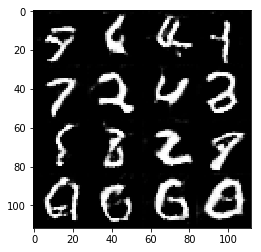

Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 1.5643
Epoch 2/2... Discriminator Loss: 0.7708... Generator Loss: 1.8556
Epoch 2/2... Discriminator Loss: 1.2179... Generator Loss: 1.3823
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 1.4966
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 3.1967
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 1.8367
Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 2.3514
Epoch 2/2... Discriminator Loss: 1.4061... Generator Loss: 0.9373
Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 1.8504
Epoch 2/2... Discriminator Loss: 1.1843... Generator Loss: 0.5648


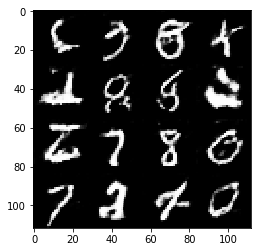

Epoch 2/2... Discriminator Loss: 1.0916... Generator Loss: 1.3537
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 1.7911
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 1.4601
Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 1.2141
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 0.6492
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 2.0447
Epoch 2/2... Discriminator Loss: 0.8302... Generator Loss: 1.7062
Epoch 2/2... Discriminator Loss: 1.0041... Generator Loss: 2.2726
Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 2.1074
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 2.4666


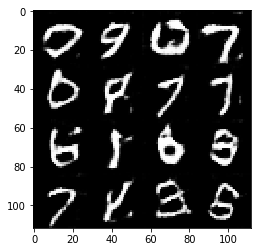

Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 1.6029
Epoch 2/2... Discriminator Loss: 0.7673... Generator Loss: 1.8257
Epoch 2/2... Discriminator Loss: 1.4700... Generator Loss: 0.8152
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 2.3537
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.7976
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 1.7443
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 2.5391


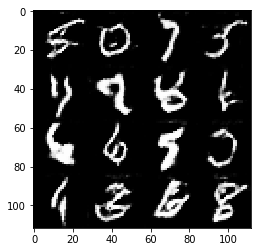

In [43]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 1.4667
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 6.0599
Epoch 1/2... Discriminator Loss: 0.9191... Generator Loss: 2.5364
Epoch 1/2... Discriminator Loss: 4.4648... Generator Loss: 0.0595
Epoch 1/2... Discriminator Loss: 2.4295... Generator Loss: 7.2411
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 6.3991
Epoch 1/2... Discriminator Loss: 1.4313... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 1.6915... Generator Loss: 5.4828
Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 2.0693
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 2.4636


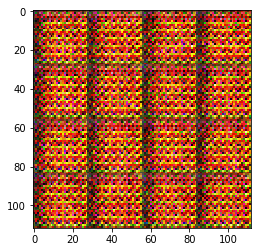

Epoch 1/2... Discriminator Loss: 0.8593... Generator Loss: 1.9279
Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 4.0361
Epoch 1/2... Discriminator Loss: 0.5133... Generator Loss: 5.0798
Epoch 1/2... Discriminator Loss: 0.6991... Generator Loss: 3.0202
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 0.9874
Epoch 1/2... Discriminator Loss: 0.5606... Generator Loss: 4.3480
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 1.6014
Epoch 1/2... Discriminator Loss: 0.4288... Generator Loss: 4.3413
Epoch 1/2... Discriminator Loss: 0.5725... Generator Loss: 2.2805
Epoch 1/2... Discriminator Loss: 2.1614... Generator Loss: 0.5281


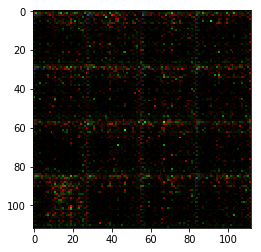

Epoch 1/2... Discriminator Loss: 0.8528... Generator Loss: 1.9994
Epoch 1/2... Discriminator Loss: 0.5404... Generator Loss: 3.0043
Epoch 1/2... Discriminator Loss: 0.7773... Generator Loss: 1.3226
Epoch 1/2... Discriminator Loss: 1.4579... Generator Loss: 0.8994
Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 1.3157
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 1.9286
Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 3.4257
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 2.2809
Epoch 1/2... Discriminator Loss: 0.6748... Generator Loss: 2.3273
Epoch 1/2... Discriminator Loss: 0.6352... Generator Loss: 2.6435


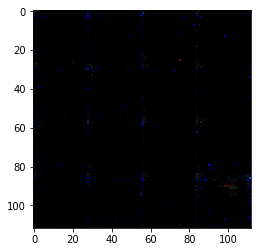

Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 1.8658
Epoch 1/2... Discriminator Loss: 1.0152... Generator Loss: 1.9523
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 1.2139
Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 1.9508
Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 1.5233
Epoch 1/2... Discriminator Loss: 0.7438... Generator Loss: 1.7377
Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 4.0421
Epoch 1/2... Discriminator Loss: 0.9066... Generator Loss: 2.1716
Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 2.2375
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 2.5989


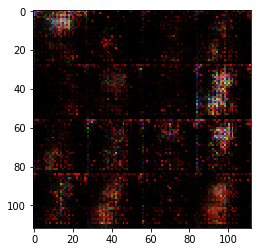

Epoch 1/2... Discriminator Loss: 0.7804... Generator Loss: 2.0228
Epoch 1/2... Discriminator Loss: 0.8737... Generator Loss: 2.2031
Epoch 1/2... Discriminator Loss: 2.2303... Generator Loss: 5.0810
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 1.9321
Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 1.9316
Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.9125
Epoch 1/2... Discriminator Loss: 0.6855... Generator Loss: 2.7150
Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 2.1154
Epoch 1/2... Discriminator Loss: 2.1056... Generator Loss: 6.1703
Epoch 1/2... Discriminator Loss: 1.0836... Generator Loss: 2.0474


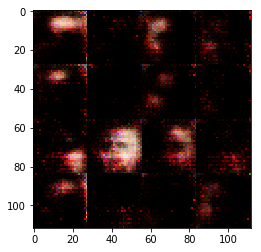

Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 1.4931
Epoch 1/2... Discriminator Loss: 0.9715... Generator Loss: 1.7335
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 1.6535
Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 2.9181
Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 1.3333
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.6244
Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 0.8974
Epoch 1/2... Discriminator Loss: 1.7102... Generator Loss: 0.5706
Epoch 1/2... Discriminator Loss: 1.5757... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.1471... Generator Loss: 1.5068


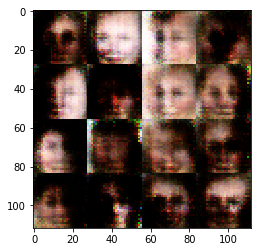

Epoch 1/2... Discriminator Loss: 1.4493... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 1.5983... Generator Loss: 0.4808
Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 3.3181
Epoch 1/2... Discriminator Loss: 1.1168... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 1.3541
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 1.1032
Epoch 1/2... Discriminator Loss: 1.0592... Generator Loss: 2.3619
Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 2.8001
Epoch 1/2... Discriminator Loss: 0.9627... Generator Loss: 2.3038
Epoch 1/2... Discriminator Loss: 1.7392... Generator Loss: 0.5106


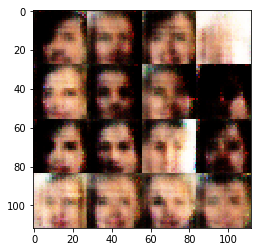

Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 1.2866
Epoch 1/2... Discriminator Loss: 1.0212... Generator Loss: 1.8688
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 1.1741
Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 1.5765
Epoch 1/2... Discriminator Loss: 1.0357... Generator Loss: 1.4605
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 3.1661
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 2.5418
Epoch 1/2... Discriminator Loss: 0.9091... Generator Loss: 1.3473
Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 2.6573
Epoch 1/2... Discriminator Loss: 0.9441... Generator Loss: 1.1697


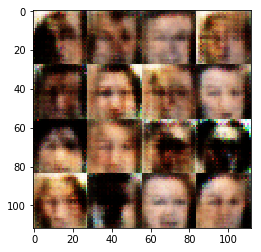

Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 1.5070
Epoch 1/2... Discriminator Loss: 1.5167... Generator Loss: 3.4296
Epoch 1/2... Discriminator Loss: 0.8980... Generator Loss: 1.8172
Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 1.6210
Epoch 1/2... Discriminator Loss: 1.4737... Generator Loss: 1.0167
Epoch 1/2... Discriminator Loss: 0.9861... Generator Loss: 1.8016
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.6433
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 1.2123
Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 2.5440
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 1.4187


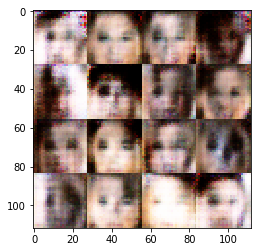

Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 2.0825... Generator Loss: 3.2964
Epoch 1/2... Discriminator Loss: 1.1974... Generator Loss: 1.2660
Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 0.8594
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 1.1031
Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 2.9979
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 3.0628
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 1.0558
Epoch 1/2... Discriminator Loss: 0.9683... Generator Loss: 1.3115


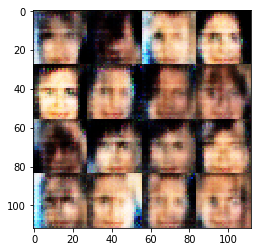

Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 1.7592
Epoch 1/2... Discriminator Loss: 1.1803... Generator Loss: 0.9539
Epoch 1/2... Discriminator Loss: 1.4624... Generator Loss: 1.6606
Epoch 1/2... Discriminator Loss: 2.3758... Generator Loss: 0.3009
Epoch 1/2... Discriminator Loss: 1.4493... Generator Loss: 0.8299
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 1.6464
Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 1.7701
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 0.9826
Epoch 1/2... Discriminator Loss: 1.2704... Generator Loss: 0.8602
Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 1.3738


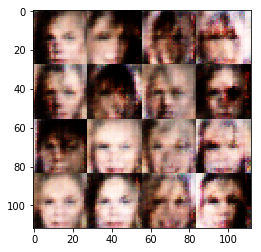

Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 2.2723
Epoch 1/2... Discriminator Loss: 1.4464... Generator Loss: 0.8159
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 1.6680
Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 1.2778
Epoch 1/2... Discriminator Loss: 1.4777... Generator Loss: 2.2008
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.7686
Epoch 1/2... Discriminator Loss: 0.9322... Generator Loss: 2.0854
Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 1.2262
Epoch 1/2... Discriminator Loss: 1.0322... Generator Loss: 1.2573
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 1.1313


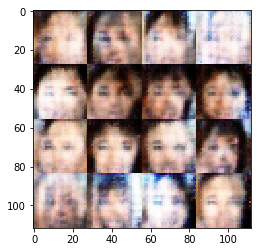

Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 0.9323
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 1.3305
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 2.0631
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 1.4032
Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 1.3497
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 1.5616
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 1.5544
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 1.1816


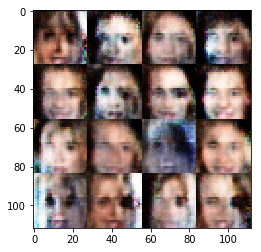

Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 0.8731
Epoch 1/2... Discriminator Loss: 2.0755... Generator Loss: 0.3954
Epoch 1/2... Discriminator Loss: 1.5835... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 1.2505
Epoch 1/2... Discriminator Loss: 1.1213... Generator Loss: 1.2966
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 1.4686
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 1.0687
Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 1.4136
Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 1.6090
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 1.1497


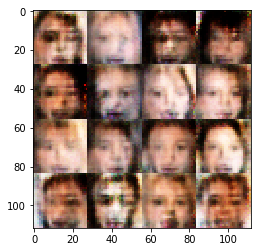

Epoch 1/2... Discriminator Loss: 1.2982... Generator Loss: 1.3265
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 0.6837
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 1.2181
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 1.1022
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 1.2791
Epoch 1/2... Discriminator Loss: 1.6469... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 1.0870
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 1.0391
Epoch 1/2... Discriminator Loss: 1.6139... Generator Loss: 2.3150


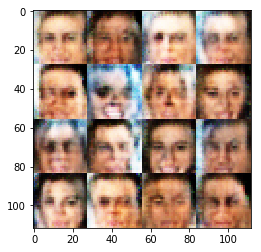

Epoch 1/2... Discriminator Loss: 1.6343... Generator Loss: 0.5838
Epoch 1/2... Discriminator Loss: 1.2094... Generator Loss: 0.9240
Epoch 1/2... Discriminator Loss: 1.7243... Generator Loss: 0.4223
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 1.4687
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 1.1317
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 2.0709
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 1.1041
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 1.2657
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.8354
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 1.2597


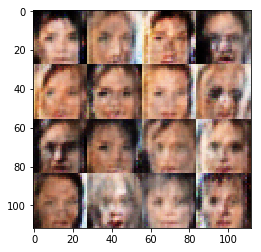

Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 1.1572
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.8685
Epoch 1/2... Discriminator Loss: 0.9804... Generator Loss: 1.0959
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 1.2426
Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 1.2483
Epoch 1/2... Discriminator Loss: 1.4379... Generator Loss: 0.7096
Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.7793
Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 1.4514


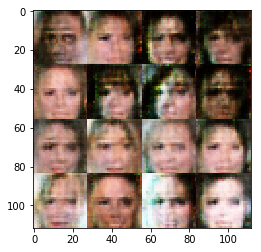

Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 1.0763
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 1.0874
Epoch 1/2... Discriminator Loss: 1.4944... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.5805... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 1.0987
Epoch 1/2... Discriminator Loss: 1.5346... Generator Loss: 0.9531
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 1.2001
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 1.1479
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 1.2976


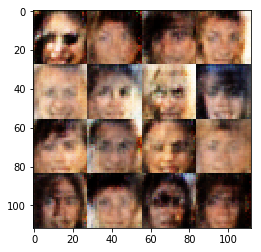

Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 1.1147
Epoch 1/2... Discriminator Loss: 1.0990... Generator Loss: 1.2182
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.9643
Epoch 1/2... Discriminator Loss: 1.6153... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 1.5134... Generator Loss: 0.7960
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 1.6696... Generator Loss: 0.5649
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.1301
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.8614


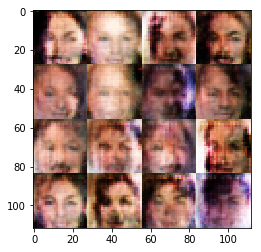

Epoch 1/2... Discriminator Loss: 1.7495... Generator Loss: 0.7009
Epoch 1/2... Discriminator Loss: 1.6570... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 1.2984
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 1.1883
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 1.3579
Epoch 1/2... Discriminator Loss: 1.5686... Generator Loss: 0.8402
Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 1.3151
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 1.0489
Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 1.0022
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 1.1413


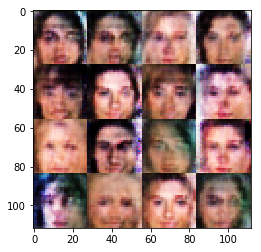

Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 1.1041
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 2.1015
Epoch 1/2... Discriminator Loss: 1.3136... Generator Loss: 1.1284
Epoch 1/2... Discriminator Loss: 1.6149... Generator Loss: 0.6207
Epoch 1/2... Discriminator Loss: 1.4222... Generator Loss: 1.0355
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 1.0500
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 1.0317
Epoch 1/2... Discriminator Loss: 1.0701... Generator Loss: 1.5540
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 1.1153
Epoch 1/2... Discriminator Loss: 1.0001... Generator Loss: 1.1106


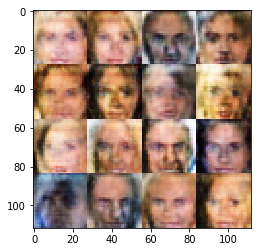

Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 1.3641
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 1.0584
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 1.2461
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 1.3193
Epoch 1/2... Discriminator Loss: 1.5139... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 1.3140... Generator Loss: 1.0124
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 1.3498
Epoch 1/2... Discriminator Loss: 1.1736... Generator Loss: 0.9902
Epoch 1/2... Discriminator Loss: 1.4024... Generator Loss: 0.8592


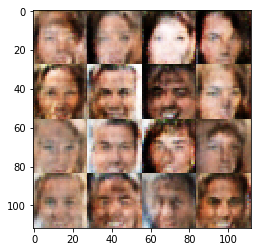

Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 1.0267
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 1.1846
Epoch 1/2... Discriminator Loss: 1.1494... Generator Loss: 1.0897
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.9340
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.9693
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 1.6125... Generator Loss: 0.8928
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 1.0639
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 1.5139


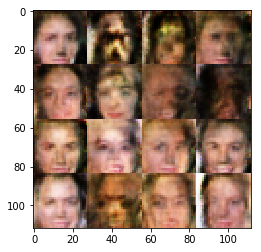

Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.9321
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 1.2613
Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 0.9256
Epoch 1/2... Discriminator Loss: 1.6166... Generator Loss: 1.0056
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 0.8893
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.6108
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.9355
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 0.8074
Epoch 1/2... Discriminator Loss: 1.2274... Generator Loss: 0.9348
Epoch 1/2... Discriminator Loss: 1.2551... Generator Loss: 0.9199


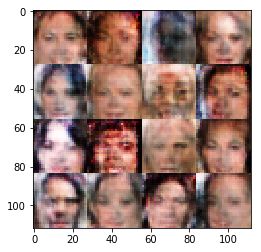

Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 1.0561
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 0.9679
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 1.1150
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.9120
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 1.4747... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.8759
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 1.6998
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.9378


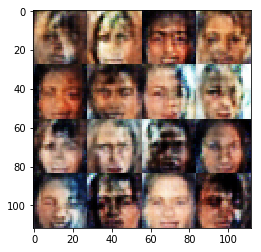

Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 0.7763
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.7724
Epoch 1/2... Discriminator Loss: 1.2773... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.6079
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.8622
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 1.0206


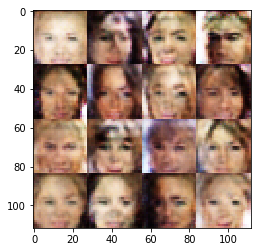

Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.4758... Generator Loss: 0.6731
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 0.9849
Epoch 1/2... Discriminator Loss: 1.0741... Generator Loss: 1.2236
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.8592
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 1.0651
Epoch 1/2... Discriminator Loss: 1.5832... Generator Loss: 0.8831
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 1.0553
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.7894


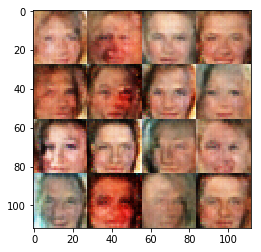

Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 1.1040
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 0.9831
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 0.9083
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.5034... Generator Loss: 1.7608
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 1.1998
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 1.5062
Epoch 1/2... Discriminator Loss: 1.5600... Generator Loss: 1.0124
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 1.2693
Epoch 1/2... Discriminator Loss: 1.7079... Generator Loss: 0.6315


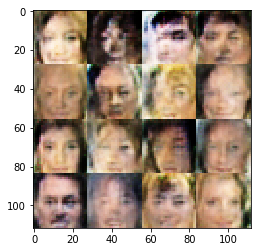

Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.9089
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 1.0724
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 1.1946
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.8053
Epoch 1/2... Discriminator Loss: 1.5551... Generator Loss: 0.5883
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.7889
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.8114
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 0.9953
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.9890


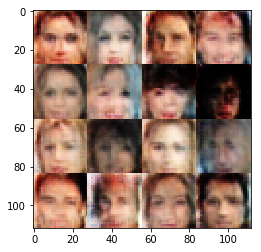

Epoch 1/2... Discriminator Loss: 1.7560... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.9642
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 1.0429
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 0.9833
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 1.0854
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 1.0855
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.9036
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 1.1751
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 0.9309


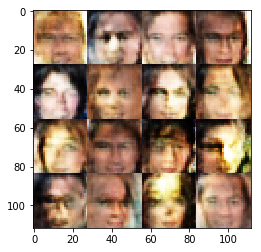

Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 1.3814
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 0.9700
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 1.0408
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.9003
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 1.1618
Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.8651
Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 1.0053


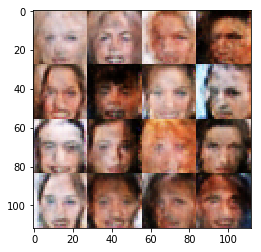

Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 1.1332
Epoch 1/2... Discriminator Loss: 1.2244... Generator Loss: 0.9991
Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.8364
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 1.0444
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 1.1983... Generator Loss: 1.0646
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.6249
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 1.5643


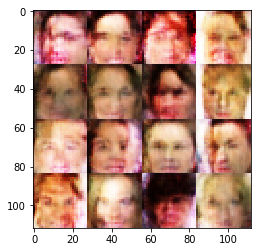

Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 1.3121
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 1.0889
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 1.2593
Epoch 1/2... Discriminator Loss: 1.5294... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 1.0157
Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 0.9515
Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 1.1613
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 1.1093
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 1.1061


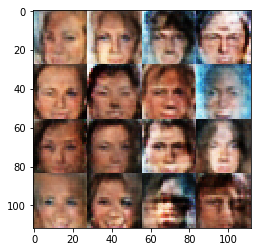

Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 0.6837
Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 0.9899
Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 1.0839
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 1.0888
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 1.0754
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 1.3852
Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 1.0377
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 1.1718
Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 1.0940


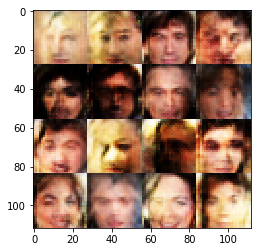

Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 1.1701
Epoch 1/2... Discriminator Loss: 1.4361... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.4505... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 1.3124... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 1.6958... Generator Loss: 0.7029
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 1.0361
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 0.8287
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.8514
Epoch 1/2... Discriminator Loss: 1.1914... Generator Loss: 1.1445
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.9251


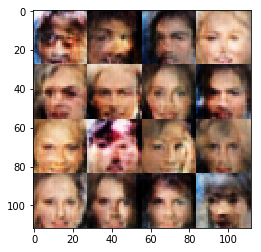

Epoch 1/2... Discriminator Loss: 1.7076... Generator Loss: 0.4768
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.9568
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 1.1175
Epoch 1/2... Discriminator Loss: 1.1342... Generator Loss: 1.2703
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 0.9994
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.9428
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.5318... Generator Loss: 0.7776


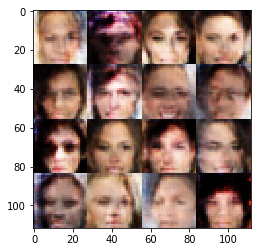

Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.9064
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 1.0838
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.5257... Generator Loss: 0.9601
Epoch 1/2... Discriminator Loss: 1.4639... Generator Loss: 1.0960
Epoch 1/2... Discriminator Loss: 1.3188... Generator Loss: 0.9853
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.6940


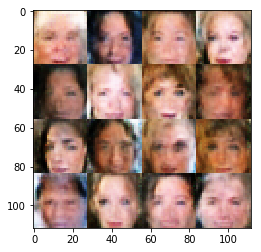

Epoch 1/2... Discriminator Loss: 1.2299... Generator Loss: 0.7754
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 1.0632
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.8662
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 1.1328
Epoch 1/2... Discriminator Loss: 1.2829... Generator Loss: 1.0085
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.9358
Epoch 1/2... Discriminator Loss: 1.3220... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 0.7792
Epoch 1/2... Discriminator Loss: 1.5570... Generator Loss: 0.9349


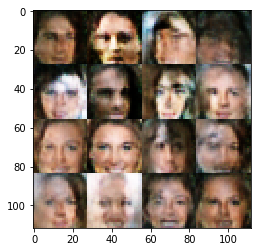

Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.9782
Epoch 1/2... Discriminator Loss: 1.2792... Generator Loss: 1.1150
Epoch 1/2... Discriminator Loss: 1.6030... Generator Loss: 0.6025
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 1.1834
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 1.2488
Epoch 1/2... Discriminator Loss: 1.3144... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.6999
Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 1.1063
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.8903
Epoch 1/2... Discriminator Loss: 1.6125... Generator Loss: 0.7711


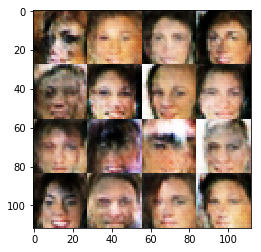

Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 1.0223
Epoch 1/2... Discriminator Loss: 1.5230... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 0.8659
Epoch 1/2... Discriminator Loss: 1.5290... Generator Loss: 0.7189
Epoch 1/2... Discriminator Loss: 1.6124... Generator Loss: 0.4669
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 1.6177
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 0.9900
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 0.8313
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 1.0832


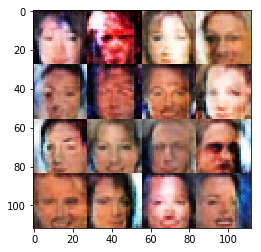

Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 1.0153
Epoch 1/2... Discriminator Loss: 1.1555... Generator Loss: 0.7877
Epoch 1/2... Discriminator Loss: 1.3433... Generator Loss: 1.5890
Epoch 1/2... Discriminator Loss: 1.5810... Generator Loss: 0.6748
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 1.0104
Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 1.6300... Generator Loss: 0.6509
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 0.8781
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 0.7386


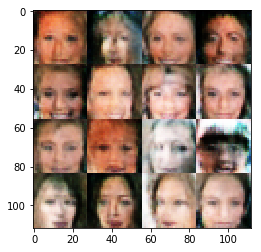

Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 1.1074
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.9938
Epoch 1/2... Discriminator Loss: 1.4106... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.9968
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.8537
Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 1.0000
Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 0.7640
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.6996


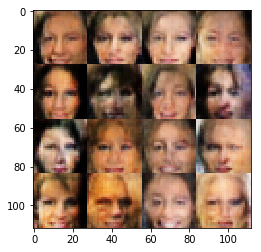

Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 0.7673
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.8971
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.8936
Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 1.3533
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.7405
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 1.0046
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 1.5274
Epoch 1/2... Discriminator Loss: 1.5402... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 1.5719... Generator Loss: 1.2613


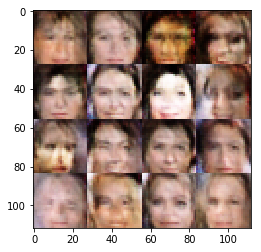

Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 1.1483
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 0.9514
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 0.7775
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.8140
Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.5403... Generator Loss: 0.9241
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.9647
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 1.1501
Epoch 1/2... Discriminator Loss: 1.6077... Generator Loss: 0.9203


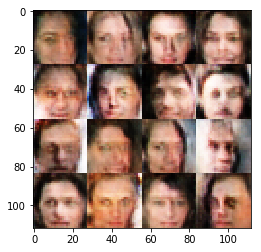

Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 0.5817
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 0.7514
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.9241
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 1.1916
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 1.0258
Epoch 1/2... Discriminator Loss: 1.3275... Generator Loss: 0.6780
Epoch 1/2... Discriminator Loss: 1.5911... Generator Loss: 0.9705
Epoch 1/2... Discriminator Loss: 1.2930... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.3713... Generator Loss: 0.9206
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 1.1297


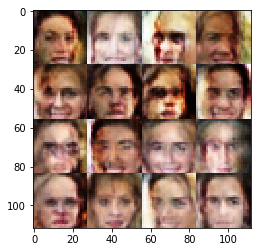

Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.9447
Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.7079
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.8368
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 1.0778
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 0.6894
Epoch 1/2... Discriminator Loss: 1.5485... Generator Loss: 0.6405
Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 0.8229
Epoch 1/2... Discriminator Loss: 1.2975... Generator Loss: 0.9330


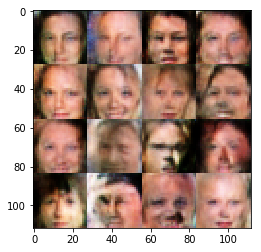

Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.8580
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 0.8796
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.9518
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.8462
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 0.8447
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 1.2624
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 1.0752
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.6260
Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 1.0021


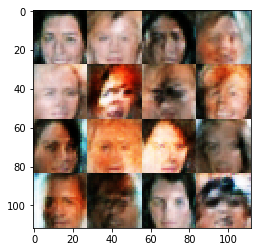

Epoch 1/2... Discriminator Loss: 1.2406... Generator Loss: 1.0115
Epoch 1/2... Discriminator Loss: 1.4383... Generator Loss: 0.6988
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.9250
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 0.7848
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 1.0381
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.8346
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 1.1122
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.6316... Generator Loss: 0.9850
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.8064


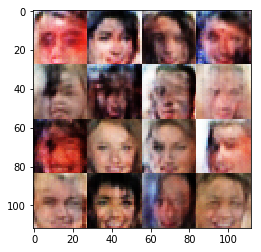

Epoch 1/2... Discriminator Loss: 1.5768... Generator Loss: 0.9464
Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 0.8157
Epoch 1/2... Discriminator Loss: 1.5912... Generator Loss: 0.7156
Epoch 1/2... Discriminator Loss: 1.2920... Generator Loss: 1.4594
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 1.0798
Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 0.9982
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.9720
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 0.8436


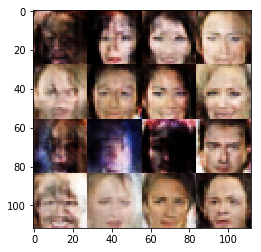

Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 1.1008
Epoch 1/2... Discriminator Loss: 1.4457... Generator Loss: 1.0609
Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 0.8055
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.5015... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 0.8168
Epoch 1/2... Discriminator Loss: 1.5503... Generator Loss: 0.4750
Epoch 1/2... Discriminator Loss: 1.4810... Generator Loss: 0.6621
Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 1.0520
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.7294


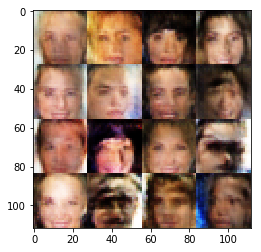

Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.9508
Epoch 1/2... Discriminator Loss: 1.5757... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.4210... Generator Loss: 0.7215
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 0.9363
Epoch 1/2... Discriminator Loss: 1.3393... Generator Loss: 0.8609


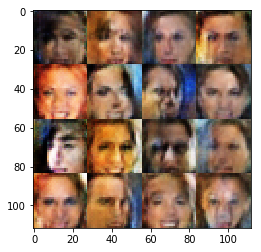

Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 1.0556
Epoch 1/2... Discriminator Loss: 1.2729... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 1.3034... Generator Loss: 1.0629
Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 0.8635
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.9649
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.8844
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 1.2624
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.8871
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.8292


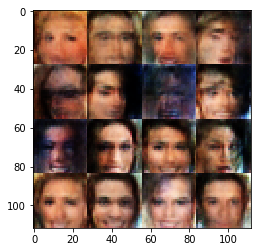

Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.9288
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 1.0137
Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 0.8934
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 1.5715... Generator Loss: 0.6132
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.7932
Epoch 1/2... Discriminator Loss: 1.2893... Generator Loss: 0.9185
Epoch 1/2... Discriminator Loss: 1.4790... Generator Loss: 0.7745
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 0.8381
Epoch 1/2... Discriminator Loss: 1.4517... Generator Loss: 0.7699


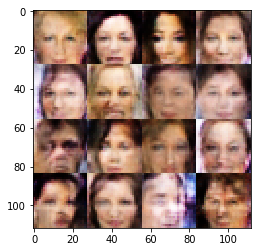

Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 1.4877... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 0.9418
Epoch 1/2... Discriminator Loss: 1.5938... Generator Loss: 1.0711
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.7593
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.9123
Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 0.9127
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 1.5408... Generator Loss: 0.6663


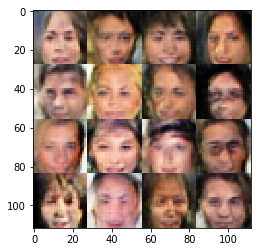

Epoch 1/2... Discriminator Loss: 1.1913... Generator Loss: 0.8269
Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 0.7838
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 0.9375
Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 1.5678
Epoch 1/2... Discriminator Loss: 1.6881... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.9061
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 0.6433
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 0.6938
Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 1.1228
Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 1.1473


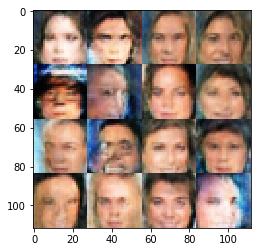

Epoch 1/2... Discriminator Loss: 1.2482... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 0.5719
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.6374... Generator Loss: 0.7478
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 0.9157
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 0.9392
Epoch 1/2... Discriminator Loss: 1.4498... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.9080
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.2956... Generator Loss: 1.2004


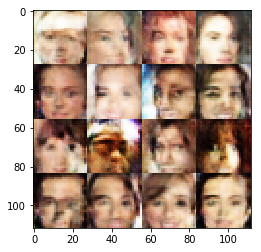

Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 0.9327
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 1.0356
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 1.2797... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 1.1434
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 0.8456
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.3264... Generator Loss: 0.9284


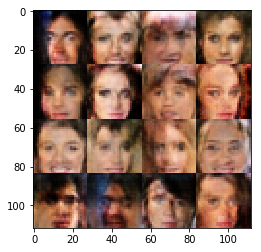

Epoch 1/2... Discriminator Loss: 1.4141... Generator Loss: 0.8765
Epoch 1/2... Discriminator Loss: 1.4984... Generator Loss: 0.6539
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 0.9487
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 0.9414
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 1.5609... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 1.5476... Generator Loss: 1.0098


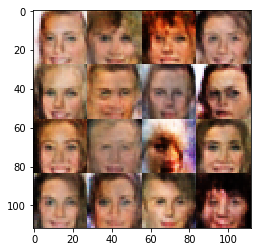

Epoch 1/2... Discriminator Loss: 1.4152... Generator Loss: 1.0736
Epoch 1/2... Discriminator Loss: 1.1887... Generator Loss: 1.0416
Epoch 1/2... Discriminator Loss: 1.5016... Generator Loss: 1.2290
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.9419
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.7747
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 1.4807
Epoch 1/2... Discriminator Loss: 1.2968... Generator Loss: 0.7568
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 1.1236
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 0.9254


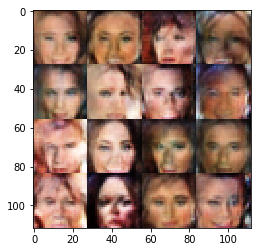

Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.5312... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 1.1106
Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.4824... Generator Loss: 0.5581
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 1.0572
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.8913
Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 1.1215
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.9690


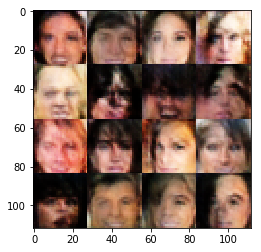

Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 1.2040
Epoch 1/2... Discriminator Loss: 1.2027... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 1.0256
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 0.7195
Epoch 1/2... Discriminator Loss: 1.3924... Generator Loss: 0.9495
Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.6155
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 0.8631
Epoch 1/2... Discriminator Loss: 1.6022... Generator Loss: 0.9464
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 0.8422


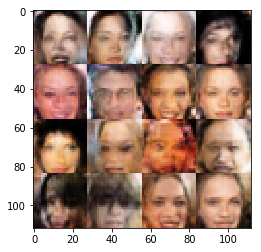

Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 0.7956
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 1.1097
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 1.1963
Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 1.5130... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 0.9098
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 1.1295
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 1.0894
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 0.9060


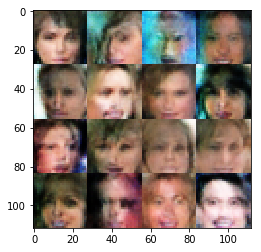

Epoch 1/2... Discriminator Loss: 1.3318... Generator Loss: 1.1191
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 0.9220
Epoch 1/2... Discriminator Loss: 1.6663... Generator Loss: 1.3048
Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 1.1362
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 0.7380
Epoch 1/2... Discriminator Loss: 1.2437... Generator Loss: 0.8477
Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.6743


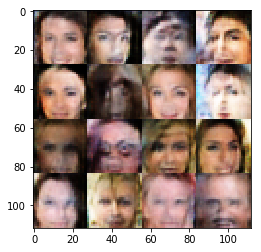

Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.8044


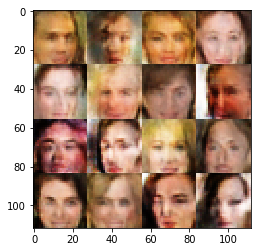

Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 0.6412
Epoch 2/2... Discriminator Loss: 1.5995... Generator Loss: 0.9115
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 1.5099... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 1.0379
Epoch 2/2... Discriminator Loss: 1.2528... Generator Loss: 0.7675
Epoch 2/2... Discriminator Loss: 1.6130... Generator Loss: 0.8808
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8577
Epoch 2/2... Discriminator Loss: 1.2738... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 1.5385... Generator Loss: 0.7890


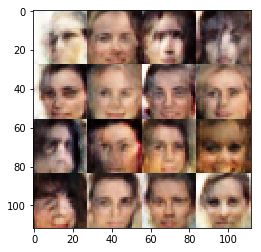

Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 1.4052... Generator Loss: 0.6728
Epoch 2/2... Discriminator Loss: 1.5372... Generator Loss: 0.6647
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 1.0004
Epoch 2/2... Discriminator Loss: 1.2297... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.5849... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.4789... Generator Loss: 0.9574
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.8090
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 1.0025


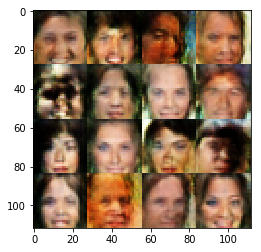

Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 0.9169
Epoch 2/2... Discriminator Loss: 1.4717... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 1.4397... Generator Loss: 1.4366
Epoch 2/2... Discriminator Loss: 1.3615... Generator Loss: 1.0075
Epoch 2/2... Discriminator Loss: 1.6270... Generator Loss: 1.0790
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 1.2748... Generator Loss: 1.2289
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.8538
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 0.7695


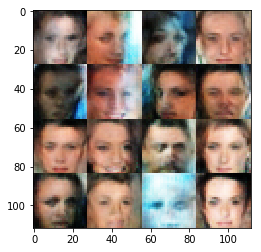

Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.6802
Epoch 2/2... Discriminator Loss: 1.2908... Generator Loss: 0.8807
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 1.1263
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.8932
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 1.0378
Epoch 2/2... Discriminator Loss: 1.2951... Generator Loss: 1.5989
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.8102
Epoch 2/2... Discriminator Loss: 1.4071... Generator Loss: 0.7390
Epoch 2/2... Discriminator Loss: 1.1551... Generator Loss: 0.8434


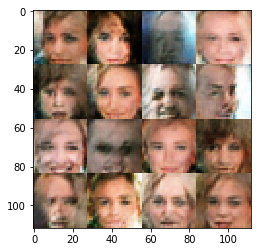

Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 0.7050
Epoch 2/2... Discriminator Loss: 1.5368... Generator Loss: 1.3198
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 1.0069
Epoch 2/2... Discriminator Loss: 1.5996... Generator Loss: 1.1657
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.9023
Epoch 2/2... Discriminator Loss: 1.4318... Generator Loss: 1.3752
Epoch 2/2... Discriminator Loss: 1.3413... Generator Loss: 0.8097
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 1.5992... Generator Loss: 0.6448


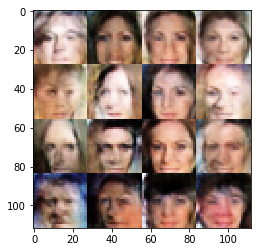

Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.8907
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 1.3327
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 0.7599
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 1.3688
Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 1.1397
Epoch 2/2... Discriminator Loss: 1.3413... Generator Loss: 0.7450
Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.8500
Epoch 2/2... Discriminator Loss: 1.4518... Generator Loss: 0.6599


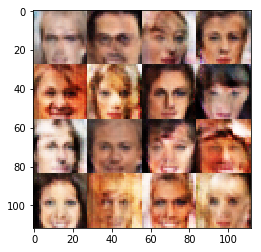

Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.9939
Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 0.8434
Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 1.0641
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.9770
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 1.5868... Generator Loss: 0.8918
Epoch 2/2... Discriminator Loss: 1.2376... Generator Loss: 0.8197
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 0.7873
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 1.1251


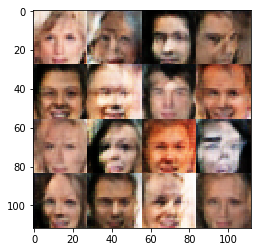

Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 1.1651
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 0.9238
Epoch 2/2... Discriminator Loss: 1.4300... Generator Loss: 1.0591
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.7379
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 0.6452
Epoch 2/2... Discriminator Loss: 1.4260... Generator Loss: 0.5389
Epoch 2/2... Discriminator Loss: 1.5917... Generator Loss: 0.4848
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.9535
Epoch 2/2... Discriminator Loss: 1.2599... Generator Loss: 0.9337


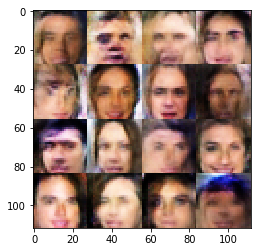

Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 1.2660... Generator Loss: 1.1474
Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 1.0595
Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 1.3407
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 1.2732... Generator Loss: 0.7665
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.4142... Generator Loss: 0.6345
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.9685
Epoch 2/2... Discriminator Loss: 1.3331... Generator Loss: 0.7046


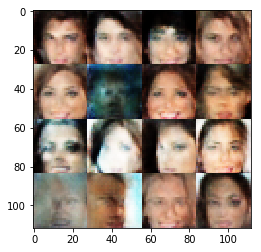

Epoch 2/2... Discriminator Loss: 1.3292... Generator Loss: 0.7841
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 1.4946... Generator Loss: 0.9827
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.7214
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 1.0156
Epoch 2/2... Discriminator Loss: 1.4700... Generator Loss: 1.0720
Epoch 2/2... Discriminator Loss: 1.2741... Generator Loss: 0.6079
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.5233
Epoch 2/2... Discriminator Loss: 1.5174... Generator Loss: 1.1777
Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 0.9082


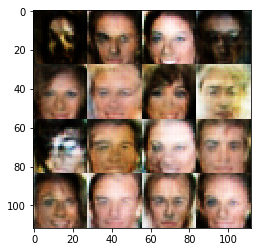

Epoch 2/2... Discriminator Loss: 1.4921... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.6888... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 1.2726... Generator Loss: 1.1388
Epoch 2/2... Discriminator Loss: 1.6182... Generator Loss: 1.0970
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.9499
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.9225
Epoch 2/2... Discriminator Loss: 1.1660... Generator Loss: 0.9529
Epoch 2/2... Discriminator Loss: 1.4015... Generator Loss: 1.2498
Epoch 2/2... Discriminator Loss: 1.5162... Generator Loss: 0.6244


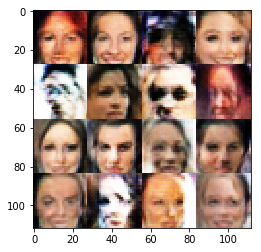

Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.6725
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 1.4003
Epoch 2/2... Discriminator Loss: 1.5118... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 1.4149... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 0.9740
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 0.7632
Epoch 2/2... Discriminator Loss: 1.6030... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 1.0908
Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 1.5787... Generator Loss: 0.8781


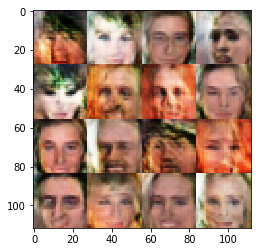

Epoch 2/2... Discriminator Loss: 1.2575... Generator Loss: 0.9977
Epoch 2/2... Discriminator Loss: 1.6448... Generator Loss: 0.5234
Epoch 2/2... Discriminator Loss: 1.0249... Generator Loss: 1.1560
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 1.5790... Generator Loss: 1.3350
Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 1.2103
Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.9938
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.9399
Epoch 2/2... Discriminator Loss: 1.4771... Generator Loss: 0.9574
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.7818


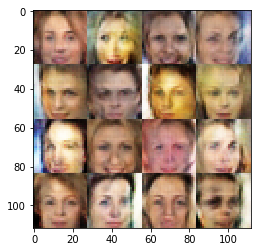

Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 1.0105
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.8378
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 1.2755
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 1.0793
Epoch 2/2... Discriminator Loss: 1.4851... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.7313
Epoch 2/2... Discriminator Loss: 1.6184... Generator Loss: 0.3983


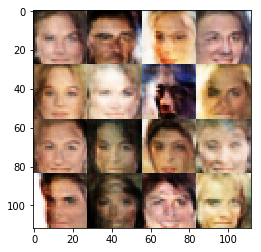

Epoch 2/2... Discriminator Loss: 1.4518... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.8505
Epoch 2/2... Discriminator Loss: 1.6275... Generator Loss: 1.3206
Epoch 2/2... Discriminator Loss: 1.6215... Generator Loss: 1.0973
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.8396
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 1.1925
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.7769


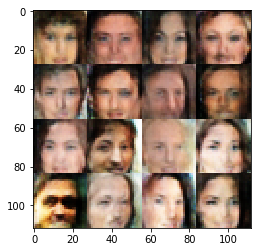

Epoch 2/2... Discriminator Loss: 1.2545... Generator Loss: 0.7130
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 0.8132
Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.8707
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.9897
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 1.3596... Generator Loss: 1.2122
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.9794
Epoch 2/2... Discriminator Loss: 1.3655... Generator Loss: 0.8724
Epoch 2/2... Discriminator Loss: 1.4134... Generator Loss: 1.0681
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 0.8939


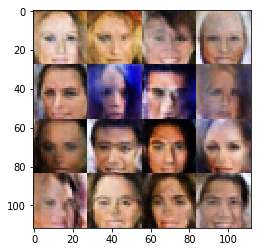

Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.8852
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.8659
Epoch 2/2... Discriminator Loss: 1.5191... Generator Loss: 1.4076
Epoch 2/2... Discriminator Loss: 1.4687... Generator Loss: 1.0155
Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 1.0528
Epoch 2/2... Discriminator Loss: 1.1786... Generator Loss: 1.0432


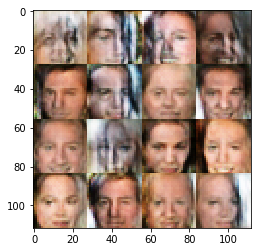

Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 1.1119
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.8174
Epoch 2/2... Discriminator Loss: 1.3555... Generator Loss: 0.9687
Epoch 2/2... Discriminator Loss: 1.4661... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.9696
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 1.4197... Generator Loss: 0.9053
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 1.2795... Generator Loss: 1.0480
Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 0.8054


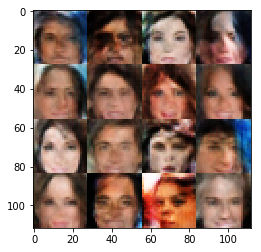

Epoch 2/2... Discriminator Loss: 1.2937... Generator Loss: 0.9857
Epoch 2/2... Discriminator Loss: 1.2847... Generator Loss: 0.8338
Epoch 2/2... Discriminator Loss: 1.1851... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 1.5367... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 1.2231... Generator Loss: 1.1614
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.6830
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 1.4601... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.8464


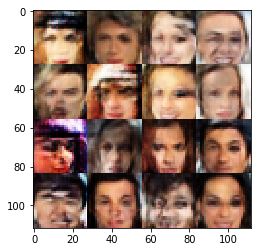

Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.9527
Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 0.9809
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.9744
Epoch 2/2... Discriminator Loss: 1.3064... Generator Loss: 1.6440
Epoch 2/2... Discriminator Loss: 1.4331... Generator Loss: 0.8735
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.9532
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 1.2393... Generator Loss: 1.0303
Epoch 2/2... Discriminator Loss: 1.1716... Generator Loss: 0.7567
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 0.9688


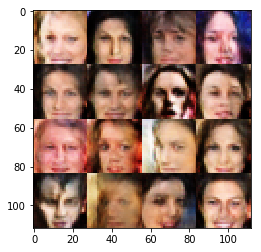

Epoch 2/2... Discriminator Loss: 1.4532... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 1.2648... Generator Loss: 0.9770
Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 0.9346
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.8671
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 0.9159
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.9128
Epoch 2/2... Discriminator Loss: 1.5456... Generator Loss: 1.2567
Epoch 2/2... Discriminator Loss: 1.2496... Generator Loss: 0.8880


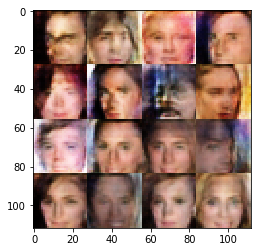

Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 1.1866
Epoch 2/2... Discriminator Loss: 1.4052... Generator Loss: 0.8243
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 1.0606
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 1.0412
Epoch 2/2... Discriminator Loss: 1.3116... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.8215
Epoch 2/2... Discriminator Loss: 1.0732... Generator Loss: 0.8203
Epoch 2/2... Discriminator Loss: 1.3015... Generator Loss: 1.4761
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 1.5590... Generator Loss: 0.7947


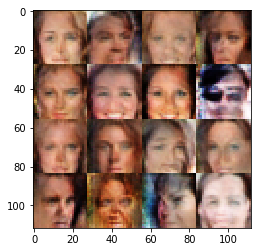

Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 0.9924
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 1.0280
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.7532
Epoch 2/2... Discriminator Loss: 1.4094... Generator Loss: 1.0845
Epoch 2/2... Discriminator Loss: 1.3191... Generator Loss: 0.7836
Epoch 2/2... Discriminator Loss: 1.4676... Generator Loss: 0.8959
Epoch 2/2... Discriminator Loss: 1.1893... Generator Loss: 0.9994
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 1.3422... Generator Loss: 0.9967


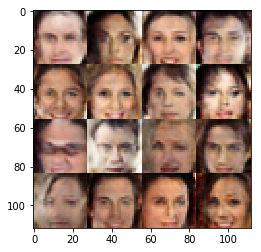

Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 1.3291
Epoch 2/2... Discriminator Loss: 1.6865... Generator Loss: 1.1998
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.7563
Epoch 2/2... Discriminator Loss: 1.2738... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 0.8666
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.8667
Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 0.6651
Epoch 2/2... Discriminator Loss: 1.3725... Generator Loss: 0.7994
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 1.0954


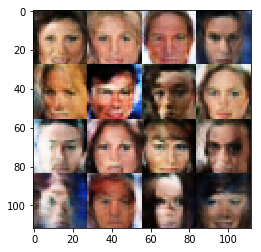

Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 0.7459
Epoch 2/2... Discriminator Loss: 1.4626... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 1.4017... Generator Loss: 1.1976
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 1.0504
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 0.7661
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.8803
Epoch 2/2... Discriminator Loss: 1.2606... Generator Loss: 0.8946


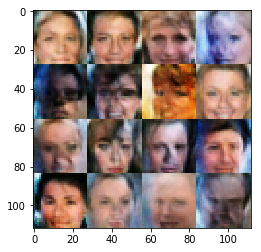

Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.8600
Epoch 2/2... Discriminator Loss: 1.5526... Generator Loss: 0.5839
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 0.7217
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.5375
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.9343
Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 0.6756
Epoch 2/2... Discriminator Loss: 1.5114... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 0.8988


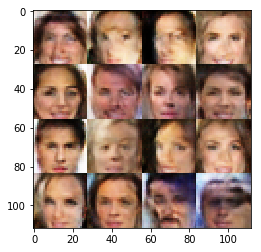

Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 1.4271
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 1.2420... Generator Loss: 1.0356
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.8615
Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 1.0660
Epoch 2/2... Discriminator Loss: 1.5516... Generator Loss: 0.6256
Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 1.1712
Epoch 2/2... Discriminator Loss: 1.4614... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 0.7956


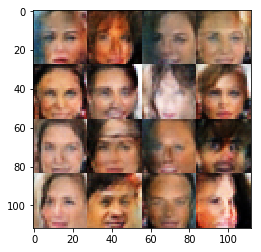

Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 1.2620
Epoch 2/2... Discriminator Loss: 1.2164... Generator Loss: 1.0270
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 0.7086
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 1.6446... Generator Loss: 0.4825
Epoch 2/2... Discriminator Loss: 1.1325... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 0.9882
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 1.1118
Epoch 2/2... Discriminator Loss: 1.4134... Generator Loss: 0.6587
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.8548


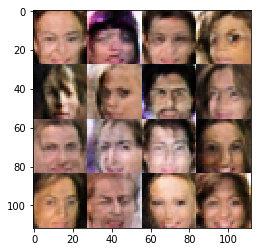

Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.6192
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.9524
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 1.0147
Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.8463
Epoch 2/2... Discriminator Loss: 1.5453... Generator Loss: 0.5889
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 1.1675... Generator Loss: 0.9463
Epoch 2/2... Discriminator Loss: 1.5047... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.8095


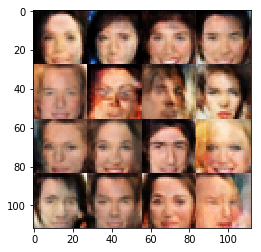

Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 1.4144
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.9590
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.4590... Generator Loss: 0.8911
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 1.1442
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 1.0629
Epoch 2/2... Discriminator Loss: 1.2250... Generator Loss: 0.8102
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 1.0733
Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 1.0313
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 1.2146


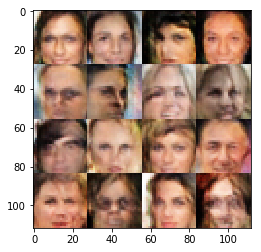

Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 0.7519
Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.2207... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 0.8610
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.8387
Epoch 2/2... Discriminator Loss: 1.3831... Generator Loss: 1.0092
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.9005


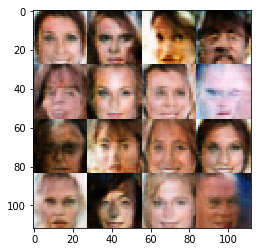

Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.7133
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 0.8322
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 1.0721
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 1.2092... Generator Loss: 1.0518
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 0.9306
Epoch 2/2... Discriminator Loss: 1.3640... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.7257
Epoch 2/2... Discriminator Loss: 1.5526... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 1.0682


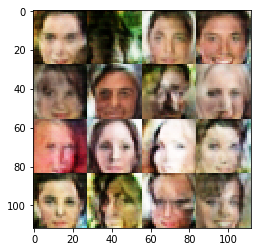

Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 1.0332
Epoch 2/2... Discriminator Loss: 1.2966... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 1.7105... Generator Loss: 0.9155
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.8986
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 0.9709
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 1.2303
Epoch 2/2... Discriminator Loss: 1.1524... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 0.8400
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 0.6569
Epoch 2/2... Discriminator Loss: 1.1189... Generator Loss: 0.8177


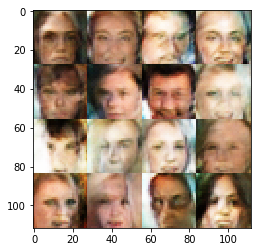

Epoch 2/2... Discriminator Loss: 1.4873... Generator Loss: 0.7996
Epoch 2/2... Discriminator Loss: 1.2116... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 1.5919... Generator Loss: 0.8180
Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 1.8474
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 1.1484
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 1.0662
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.1821... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 1.0376


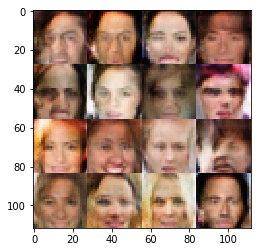

Epoch 2/2... Discriminator Loss: 1.5557... Generator Loss: 1.1565
Epoch 2/2... Discriminator Loss: 1.5615... Generator Loss: 0.7583
Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 0.7721
Epoch 2/2... Discriminator Loss: 1.4821... Generator Loss: 0.6941
Epoch 2/2... Discriminator Loss: 1.1875... Generator Loss: 0.8621
Epoch 2/2... Discriminator Loss: 1.2342... Generator Loss: 0.9932
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 1.3297... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.0298... Generator Loss: 1.0898
Epoch 2/2... Discriminator Loss: 1.1345... Generator Loss: 1.0677


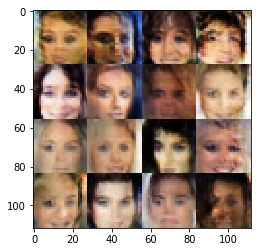

Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.7581
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 1.0001
Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 0.8496
Epoch 2/2... Discriminator Loss: 1.5454... Generator Loss: 0.6071
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 1.4682... Generator Loss: 0.8580
Epoch 2/2... Discriminator Loss: 1.5138... Generator Loss: 1.0006


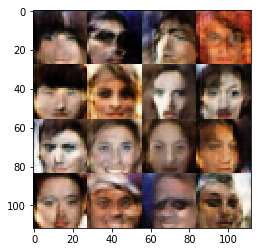

Epoch 2/2... Discriminator Loss: 1.3514... Generator Loss: 0.6444
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 1.0006
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 1.1962... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 1.3329... Generator Loss: 1.1890
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 1.0382
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 1.2950... Generator Loss: 0.6966
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 1.0355


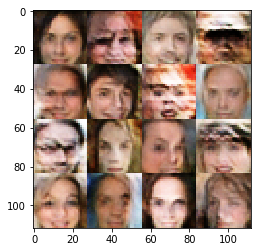

Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 1.0384
Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 1.0107
Epoch 2/2... Discriminator Loss: 1.1798... Generator Loss: 1.0286
Epoch 2/2... Discriminator Loss: 1.1043... Generator Loss: 0.8082
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 0.8751
Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 0.7533
Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 1.8450... Generator Loss: 0.3897
Epoch 2/2... Discriminator Loss: 1.5897... Generator Loss: 0.6582
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 1.0517


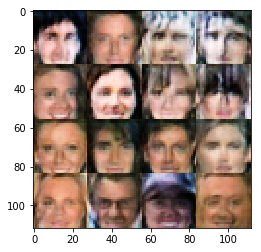

Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 0.9396
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 1.0229
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.9895
Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 1.2762
Epoch 2/2... Discriminator Loss: 1.5511... Generator Loss: 0.6192
Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 0.8635
Epoch 2/2... Discriminator Loss: 1.3543... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 0.7844
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.9077


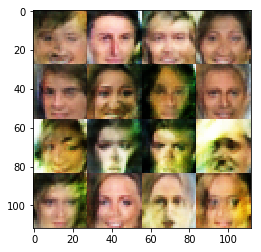

Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 1.2145... Generator Loss: 0.8183
Epoch 2/2... Discriminator Loss: 1.2966... Generator Loss: 0.9392
Epoch 2/2... Discriminator Loss: 1.4569... Generator Loss: 0.9211
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 1.1519
Epoch 2/2... Discriminator Loss: 1.4030... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 1.4390... Generator Loss: 1.0513
Epoch 2/2... Discriminator Loss: 1.5908... Generator Loss: 0.8230


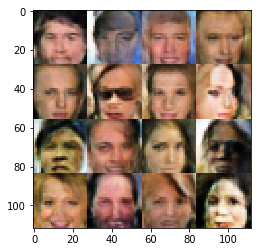

Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 0.9154
Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 1.0155
Epoch 2/2... Discriminator Loss: 1.4235... Generator Loss: 0.8792
Epoch 2/2... Discriminator Loss: 1.1821... Generator Loss: 1.0762
Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 0.6497
Epoch 2/2... Discriminator Loss: 1.2321... Generator Loss: 0.8448


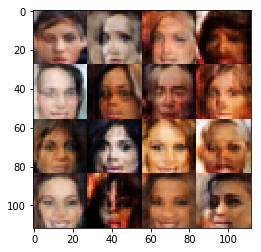

Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 1.0589
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 0.9234
Epoch 2/2... Discriminator Loss: 1.2922... Generator Loss: 0.7604
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 1.2716
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.8159
Epoch 2/2... Discriminator Loss: 1.4555... Generator Loss: 0.7810
Epoch 2/2... Discriminator Loss: 1.2231... Generator Loss: 1.0522
Epoch 2/2... Discriminator Loss: 1.1928... Generator Loss: 0.8752
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 1.1925
Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 0.8778


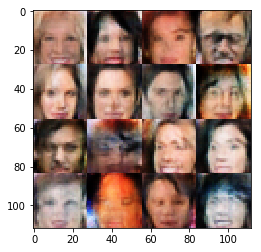

Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 1.5892... Generator Loss: 0.6163
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 1.1317
Epoch 2/2... Discriminator Loss: 1.3201... Generator Loss: 0.7800
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.6599
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 0.7839
Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 1.4508... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 0.9432


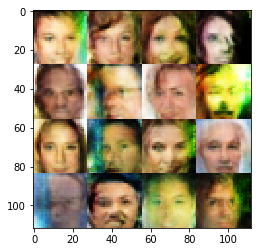

Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 1.1714
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 1.1018
Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.9100
Epoch 2/2... Discriminator Loss: 1.2783... Generator Loss: 0.9546
Epoch 2/2... Discriminator Loss: 1.4053... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 1.4277... Generator Loss: 0.6549
Epoch 2/2... Discriminator Loss: 1.3103... Generator Loss: 1.2212
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 1.0523
Epoch 2/2... Discriminator Loss: 1.1110... Generator Loss: 1.0932
Epoch 2/2... Discriminator Loss: 1.4258... Generator Loss: 1.3676


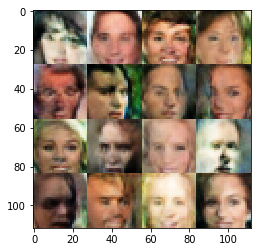

Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 1.0848
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 1.2963
Epoch 2/2... Discriminator Loss: 1.4418... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 0.8765
Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.5709
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.9539
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.6259
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 1.0072


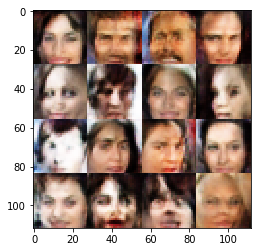

Epoch 2/2... Discriminator Loss: 1.2332... Generator Loss: 0.9409
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 1.0408
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.8347
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 0.9079
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 0.9068
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 0.7586
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 0.8273
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 0.8911


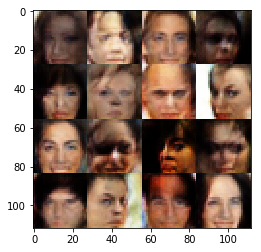

Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 0.8786
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.8484
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.4015... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 0.9509
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 1.2381... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 0.9542
Epoch 2/2... Discriminator Loss: 1.4860... Generator Loss: 0.9119
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.8002


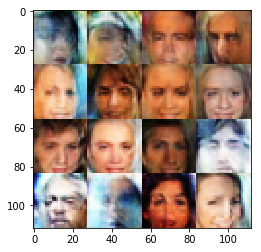

Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.7599
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 1.0394
Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 1.2017... Generator Loss: 0.8962
Epoch 2/2... Discriminator Loss: 1.2099... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 1.5521... Generator Loss: 0.7581
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.6342
Epoch 2/2... Discriminator Loss: 1.4821... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 1.4961... Generator Loss: 0.7680


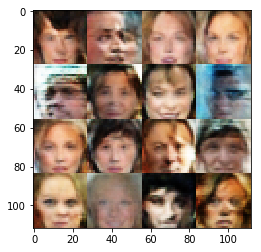

Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 1.2075
Epoch 2/2... Discriminator Loss: 1.6606... Generator Loss: 0.9574
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 0.9571
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 1.0584
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 0.6620
Epoch 2/2... Discriminator Loss: 1.2896... Generator Loss: 1.0843
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 1.1890
Epoch 2/2... Discriminator Loss: 1.2728... Generator Loss: 1.0547
Epoch 2/2... Discriminator Loss: 1.1790... Generator Loss: 0.9929
Epoch 2/2... Discriminator Loss: 1.2925... Generator Loss: 1.1560


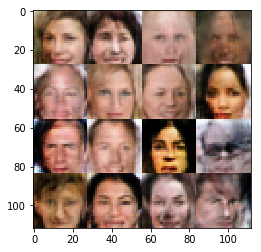

Epoch 2/2... Discriminator Loss: 1.2023... Generator Loss: 1.1590
Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 1.2461
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.8614
Epoch 2/2... Discriminator Loss: 1.4741... Generator Loss: 1.2219
Epoch 2/2... Discriminator Loss: 1.1168... Generator Loss: 0.8857
Epoch 2/2... Discriminator Loss: 1.4871... Generator Loss: 0.6574
Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.5004
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 1.0254
Epoch 2/2... Discriminator Loss: 1.1988... Generator Loss: 1.0132
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 0.9118


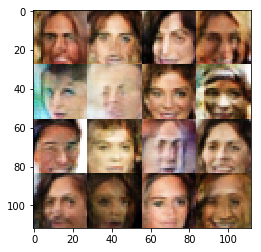

Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.6557
Epoch 2/2... Discriminator Loss: 1.5091... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 1.1114... Generator Loss: 1.0368
Epoch 2/2... Discriminator Loss: 1.4627... Generator Loss: 1.4891
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 0.8522
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 0.8408
Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 0.9460
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 1.0806


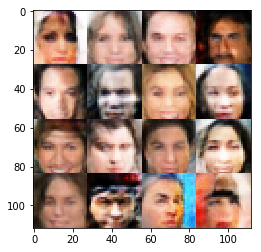

Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 1.3793
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 0.8996
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.8111
Epoch 2/2... Discriminator Loss: 1.5124... Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 1.5333... Generator Loss: 1.0791
Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 0.8979
Epoch 2/2... Discriminator Loss: 1.0401... Generator Loss: 1.0104
Epoch 2/2... Discriminator Loss: 1.3165... Generator Loss: 0.9132
Epoch 2/2... Discriminator Loss: 1.4600... Generator Loss: 0.8053


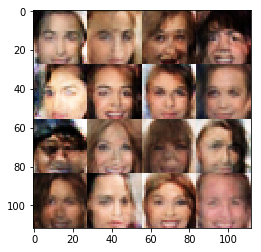

Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.5023... Generator Loss: 0.9970
Epoch 2/2... Discriminator Loss: 1.0086... Generator Loss: 1.4920
Epoch 2/2... Discriminator Loss: 1.2829... Generator Loss: 0.9249
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 1.6319... Generator Loss: 1.4242
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.9987
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.8897
Epoch 2/2... Discriminator Loss: 1.4629... Generator Loss: 0.7370
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 1.0743


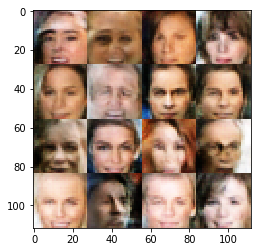

Epoch 2/2... Discriminator Loss: 1.4205... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 1.5328... Generator Loss: 1.0508
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.7469
Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 1.2673
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.6126
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.9477
Epoch 2/2... Discriminator Loss: 1.1898... Generator Loss: 0.7774
Epoch 2/2... Discriminator Loss: 1.4369... Generator Loss: 0.7369


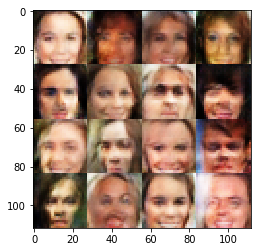

Epoch 2/2... Discriminator Loss: 1.1625... Generator Loss: 0.7888
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.6096
Epoch 2/2... Discriminator Loss: 1.2589... Generator Loss: 1.0838
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 1.0806
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.9206
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 1.0223
Epoch 2/2... Discriminator Loss: 1.6358... Generator Loss: 1.0097
Epoch 2/2... Discriminator Loss: 1.0770... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 1.3197... Generator Loss: 1.2989
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.9419


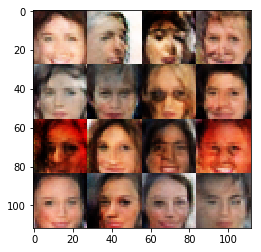

Epoch 2/2... Discriminator Loss: 1.3682... Generator Loss: 1.0179
Epoch 2/2... Discriminator Loss: 1.2359... Generator Loss: 0.9900
Epoch 2/2... Discriminator Loss: 1.3114... Generator Loss: 0.8458
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 0.7269
Epoch 2/2... Discriminator Loss: 1.1896... Generator Loss: 0.8093
Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.7966
Epoch 2/2... Discriminator Loss: 1.4420... Generator Loss: 0.6399
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 0.9921
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.8874


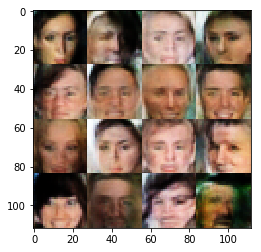

Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 0.7321
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.9098
Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.8225
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 1.2091
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 1.0782
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.9717
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.9781
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.7588


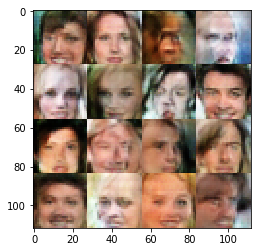

Epoch 2/2... Discriminator Loss: 1.0731... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 1.3233... Generator Loss: 0.9672
Epoch 2/2... Discriminator Loss: 1.2339... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 1.4604... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 1.3787
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.8510
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.9542
Epoch 2/2... Discriminator Loss: 1.2076... Generator Loss: 0.9772
Epoch 2/2... Discriminator Loss: 1.1096... Generator Loss: 0.9424


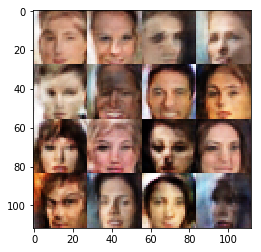

Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 1.2969
Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 1.1792
Epoch 2/2... Discriminator Loss: 1.1901... Generator Loss: 0.8428
Epoch 2/2... Discriminator Loss: 0.7621... Generator Loss: 1.1872
Epoch 2/2... Discriminator Loss: 1.5158... Generator Loss: 0.7072
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 1.3608... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.9544


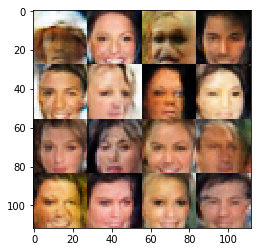

Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 1.0102
Epoch 2/2... Discriminator Loss: 1.2329... Generator Loss: 1.1126
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 0.5335
Epoch 2/2... Discriminator Loss: 1.4012... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.7604
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.8920
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.9911
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.9853
Epoch 2/2... Discriminator Loss: 1.8308... Generator Loss: 0.3436
Epoch 2/2... Discriminator Loss: 1.4924... Generator Loss: 0.6049


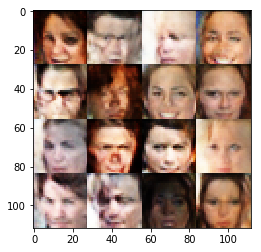

Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 0.8151
Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.9308
Epoch 2/2... Discriminator Loss: 1.4149... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 0.9488
Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 1.0136
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 1.0342
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 1.1718
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 0.8773
Epoch 2/2... Discriminator Loss: 1.1257... Generator Loss: 0.8316
Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 1.2503


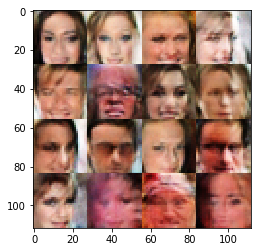

Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.9543
Epoch 2/2... Discriminator Loss: 1.3735... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 1.1575... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 1.2446
Epoch 2/2... Discriminator Loss: 1.4428... Generator Loss: 1.0871
Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 0.8495
Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 1.0479
Epoch 2/2... Discriminator Loss: 1.3085... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 0.9257
Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.8614


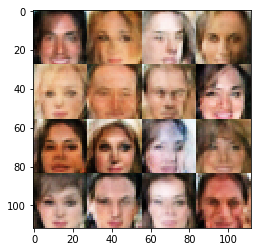

Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 1.3125... Generator Loss: 0.8726
Epoch 2/2... Discriminator Loss: 1.4455... Generator Loss: 1.2392
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 1.1368... Generator Loss: 0.8116
Epoch 2/2... Discriminator Loss: 1.5043... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 1.5126... Generator Loss: 0.7429
Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 0.8911
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.6561


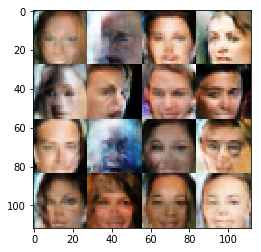

Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.8627
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 0.9389
Epoch 2/2... Discriminator Loss: 1.2641... Generator Loss: 0.9239


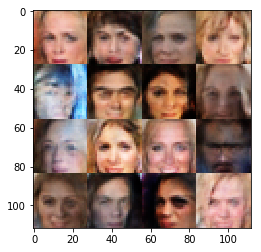

In [44]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.